# <i>Survival Analysis II</i>
## <i>Non-Parametric Estimators in lifelines</i>

<h2>The Kaplan-Meier Estimator</h2>

<p>The Kaplan-Meier estimator, also known as the product-limit estimator, is the most common non-parametric survival analysis technique, and is usually visualized as a plot. The estimator is defined as:</p>

<h1>$\hat{S}(t) = \prod_{t_i \lt t} \frac{n_i - d_i}{n_i}$</h1>

<p>where:</p>
    <ul>
        <li>$\hat{S}$ is the estimator of survival to time point $t$ and beyond</li>
        <li>$t_i$ is the time point when at least one event happened</li>
        <li>$d_i$ is the number of events happening at time point $t$</li>
        <li>$n_i$ is the number of subjects known to survive</li>
    </ul>

<p>This shows us that the survival probability at time $t$ is equal to the product of the percentage chance of surviving at time $t$ and each prior time, hence the term product-limit estimator.</p>

<p>Advantages of the Kaplan-Meier estimator include that it is very flexible, and that model complexity grows with the number of observations. Disadvantages include that it cannot easily incorporate covariates, and that the option of creating a new model for each subpopulation becomes infeasible as the number of characteristics grows. Also, the survival functions are not smooth, they are piece-wise constant.</p>

<p>Assumptions of the Kaplan-Meier estimator are that:</p>
    <ol>
        <li>The event is unambiguous and happens at a clearly specified time</li>
        <li>The survival probability is the same for all subjects, regardless of when they entered the study</li>
        <li>Censored observations have the same survival prospects, regardless of when they entered the study</li>
    </ol>

### Import Libraries and Data

First, we'll import libraries and data.

In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

data = lifelines.datasets.load_gbsg2()
print(np.shape(data))
data.head()

(686, 10)


,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


## Kaplan-Meier Fitter

Then, fit a Kaplan Meier model to the overall data.

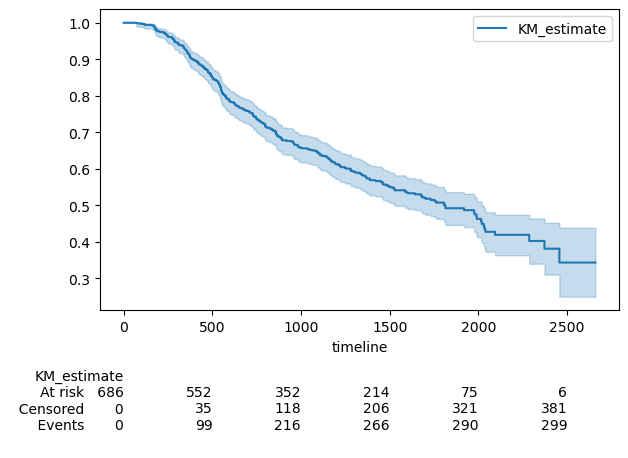

In [2]:
T = data["time"]
E = data["cens"]
kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)
kmf.plot_survival_function(at_risk_counts=True);

### Breakout by Characteristic

We can run multiple Kaplan-Meier fitters in order to show a breakout in survival based on characteristics - in this case (arbitrarily), tumor grade.

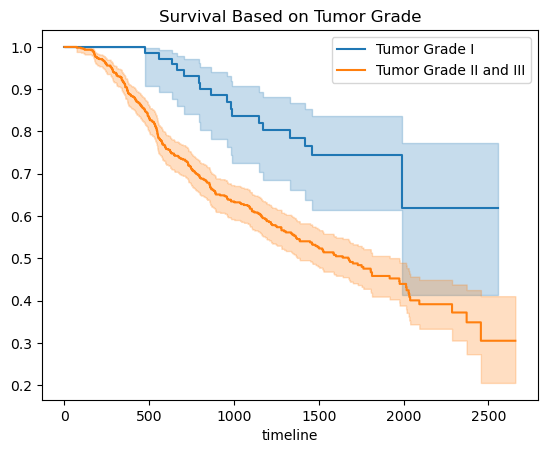

In [3]:
from lifelines.utils import median_survival_times
median_ci = median_survival_times(kmf.confidence_interval_)

kmf = KaplanMeierFitter()

g1 = data[data['tgrade'] == 'I']
g2 = data[data['tgrade'] == 'II']
g3 = data[data['tgrade'] == 'III']

ax = plt.subplot(111)

tgrade = (data["tgrade"] == "I")
kmf.fit(T[tgrade], event_observed=E[tgrade], label="Tumor Grade I")
kmf.plot_survival_function(ax=ax)

kmf.fit(T[~tgrade], event_observed=E[~tgrade], label="Tumor Grade II and III")
kmf.plot_survival_function(ax=ax)

plt.title("Survival Based on Tumor Grade");

By default, confidence intervals represent 95% confidence, but this can be tuned with the <code>alpha</code> parameter. 

# Log-Rank Test

<p>The log-rank test is used in survival analysis to compare the distribution of time to event in two or more independent groups, answering questions like "which treatment has a better survival probability". The test is non-parametric, so there is no need to use other tests in order to see if it is suitable to your dataset <b>(Udemy)</b>.</p>

The logrank test is used to test the null hypothesis that there is no difference between the populations in the probability of an event at any point <b>(BMJ)</b>.
    
The logrank test is based on the same assumptions as the Kaplan-Meier test:
<ul>
    <li>Independence</li>
    <li>Non-Informative Censoring: censoring should not be related to the event being studied or the group assignment</li>
    <li>Proportional Hazards: the hazard rates for compared groups should be consistent over time</li>
</ul>

<p>Let:</p>
    <ul>
        <li>$1, \ldots, J$ be the distinct times of observed events in either group</li>
        <li>$N_{i,j}$ and $N_{2,j}$ be the number of subjects at risk at the start of period $j$ in the groups</li>
        <li>$O_{1,j}$ and $O_{2,j}$ be the observed number of events in the groups at time $j$</li>
        <li>$N_j = N_{1,j} + N_{2,j}$</li>
        <li>$O_j = O_{1,j} + O_{2,j}$</li>
    </ul>

<p>$O_{i,j}$ has a hypergeometric distribution with parameters:</p>
    <ul>
        <li>$N_j$</li>
        <li>$N_{i,j}$</li>
        <li>$O_j$</li>
    </ul>

<p>This distribution has expected value $E_i,j = O_j \frac{ N_{i,j} }{ N_j }$, and variance equal to:</p>

<h2>$V_{i,j} = E{i,j} \left( \frac{ N_j - O_j }{ N_j } \right)  \left( \frac{ N_j - N_{i,j} }{ N_j - 1 } \right)$</h2>

<p>The variance is a part of the calculation of the logrank statistic, which is formulated as:</p>

<h2>$Z_i = \frac{ \sum_{j=1}^J (O_{i,j} - E_{i,j}) }{ \sqrt{ \sum_{j=1}^J V_{i,j} } }$</h2>

<b>source: Wikipedia</b>

In [4]:
from lifelines.statistics import logrank_test

output = logrank_test(durations_A = g1['time'],
                      durations_B = g2['time'],
                      event_observed_A = g1['cens'],
                      event_observed_B = g2['cens'])

output.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          13.67 <0.005     12.17

# Nelson-Aalen Estimator in lifelines

The survival function is not the only way to summarize and visualize the survival dataset. Unfortunately, if we are curious about the hazard function (which is the basis of additional techniques), we cannot get there simply by transforming the survival function. But there is a proper non-parametric estimator of the cumulative hazard function: the Nelson-Aalen estimator.

<h2>$\hat{H} = \sum_{t_i \le t} \frac{d_i}{n_i}$</h2>

First, we'll apply a Nelson Aalen fitter to the top-level data.

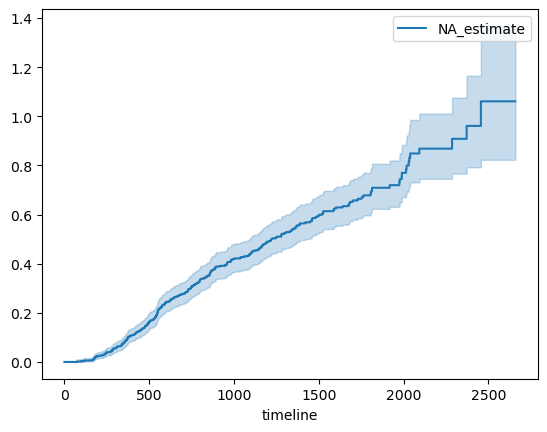

In [6]:
from lifelines import NelsonAalenFitter

T = data["time"]
E = data["cens"]

naf = NelsonAalenFitter()
naf.fit(T,event_observed=E)
naf.plot_cumulative_hazard();

### Nelson-Aalen with Tumor Grade Breakout

Now, we'll view the hazard functions with a breakout by tumor grade.

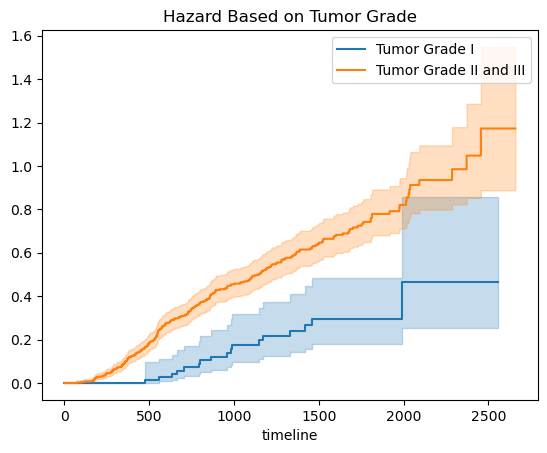

In [7]:
ax = plt.subplot(111)

tgrade = (data["tgrade"] == "I")
naf.fit(T[tgrade], event_observed=E[tgrade], label="Tumor Grade I")
naf.plot_cumulative_hazard(ax=ax)

naf.fit(T[~tgrade], event_observed=E[~tgrade], label="Tumor Grade II and III")
naf.plot_cumulative_hazard(ax=ax)

plt.title("Hazard Based on Tumor Grade");

The next article is about the Cox Proportional Hazards regression model; you can find it **here**

# References

1. (n.d.). Lifelines Documentation. Lifelines. https://lifelines.readthedocs.io/en/latest/
2. Moore, D. F. (2016). Applied Survival Analysis in R. Springer International Publishing Switzerland 2016.
3. (n.d.). Scikit-Survival Documentation. https://scikit-survival.readthedocs.io/en/stable/user_guide/index.html
4. [Udemy]. (2019, April 1). Survival Analysis in R [Video]. Udemy. https://www.udemy.com/course/survival-analysis-in-r/
5. (2019, January 6). Survival Analysis Intuition and Implementation in Python. Towards Data Science. https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
6. Lewinson, E. (2020, August 17). Introduction to Survival Analysis: The Kaplan-Meier estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-kaplan-meier-estimator-94ec5812a97a
7. Lewinson, E. (2020, July 23). The Cox Proportional Hazards Model. Towards Data Science. https://towardsdatascience.com/the-cox-proportional-hazards-model-35e60e554d8f
8. Lewinson, E. (2020, August 23). Introduction to Survival Analysis: The Nelson-Aalen estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-nelson-aalen-estimator-9780c63d549d